In [28]:
%matplotlib inline
import itertools
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display


import sys
sys.path.insert(0, './utility/')
import importlib
import double_gyre
importlib.reload(double_gyre)



<module 'double_gyre' from './utility/double_gyre.py'>

In [22]:


T0 = 0.
TMAX = 20.
factor = 3
NX = int(100*factor)
NY =  int(50*factor)

A_ = 0.1
e_ = 0.3



gyreObj = double_gyre
gyreObj.setGyreVars(A_, e_)
f = gyreObj.f
doublegyre = gyreObj.doublegyre
strain_res = 1e-2
fig_num = 'test'


In [23]:
#these should be put in another script


def grid_of_particles(N, wx=2, wy = 1.):
    # Create a grid of N (approximately) evenly spaced particles
    # covering a rectangular patch of width wx and height wy
    # centered on the point (1.0, 0.5)
    Nx = 2*int(np.sqrt(N/2))
    Ny = 1*int(np.sqrt(N/2))
    x  = np.linspace(1.0-wx/2, 1.0+wx/2, Nx)
    y  = np.linspace(0.5-wy/2, 0.5+wy/2, Ny)
    y, x = np.meshgrid(y, x)
    return np.array([x, y])

# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]

def rk4(X, t, h, f):
    k1 = f(X,          t)
    k2 = f(X + k1*h/2, t + h/2)
    k3 = f(X + k2*h/2, t + h/2)
    k4 = f(X + k3*h,   t + h)
    return X + h*(k1 + 2.*k2 + 2.*k3 + k4) / 6.


# Function to calculate endpoints from
# initial positions X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator

def endpoints(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = int((tmax - t) / h)
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
    while t < tmax:
        # Ensure we end up at correct time
        h = min(h, tmax - t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

In [24]:
# Transport parameters
t0 = T0
tmax =  TMAX
h    =  0.1

# Main grid initial points
Np   = NX*NY
X0m  = grid_of_particles(Np, wx = 2.04, wy = 1.02)
Nx   = X0m.shape[1]
Ny   = X0m.shape[2]
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]
print(dxm)
# Auxiliary grid initial points
dxa        = dxm / 200
dya        = dym / 200
X0a        = np.empty((2, 2, 2, Nx, Ny))
X1a        = np.empty((2, 2, 2, Nx, Ny))
X0a[0,0,:] = X0m + np.array([-dxa, 0]).reshape(2,1,1)
X0a[1,0,:] = X0m + np.array([ dxa, 0]).reshape(2,1,1)
X0a[0,1,:] = X0m + np.array([ 0,-dya]).reshape(2,1,1)
X0a[1,1,:] = X0m + np.array([ 0, dya]).reshape(2,1,1)

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

# Progress bar
progressbar = FloatProgress(min = 0, max = 5)
display(progressbar)

# Trajectory endpoints
X1m   = endpoints(X0m, tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[0,0,:] = endpoints(X0a[0,0,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[1,0,:] = endpoints(X0a[1,0,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[0,1,:] = endpoints(X0a[0,1,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1
X1a[1,1,:] = endpoints(X0a[1,1,:], tmax, h, rk4, f, t=t0)
progressbar.value += 1

# Flow maps
FMm = X1m - X0m
FMa = X1a - X0a

# Save results to disk
np.save('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0m)
np.save('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0a)
np.save('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1m)
np.save('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1a)
np.save('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMm)
np.save('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMa)

0.006822742474916387
Main grid consists of 300 x 150 = 45000 points.
Corners:  (-0.020000000000000018, -0.010000000000000009) (2.02, 1.01)
dxm =  0.006822742474916387 dym =  0.006845637583892617
dxa =  3.4113712374581935e-05 dya =  3.422818791946308e-05


A Jupyter Widget

In [25]:
Nx = NX
Ny =  NY
t0 = T0
tmax = TMAX

# Load data from disk
X0m = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0a = np.load('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1m = np.load('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1a = np.load('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMm = np.load('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMa = np.load('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0 = X0m
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]
# Grid parameter of auxiliary grid
dxa = X0m[0,0,0] - X0a[0,0,0,0,0]
dya = X0m[1,0,0] - X0a[0,1,1,0,0]

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

Main grid consists of 300 x 150 = 45000 points.
Corners:  (-0.020000000000000018, -0.010000000000000009) (2.02, 1.01)
dxm =  0.006822742474916387 dym =  0.006845637583892617
dxa =  3.4113712374581745e-05 dya =  3.422818791946371e-05


In [26]:
# Arrays to hold derivatives for original array and auxiliary array
dFMm = np.ones((Nx, Ny, 2, 2))
dFMa = np.ones((Nx, Ny, 2, 2))

#### Derivatives for original array ####
# dFMm_x/dx
dFMm[1:-1, :  ,0,0] = (   X1m[0,2:  , :  ] -   X1m[0, :-2, :  ] )                     / (2*dxm) # Central finite difference
dFMm[   0, :  ,0,0] = ( 4*X1m[0,   1, :  ] - 3*X1m[0,   0, :  ] - 2*X1m[0,   2, :  ]) / (2*dxm)  # One-sided finite difference
dFMm[  -1, :  ,0,0] = ( 3*X1m[0,  -1, :  ] - 4*X1m[0,  -2, :  ] + 2*X1m[0,  -3, :  ]) / (2*dxm)  # One-sided finite difference
# dFMm_x/dy
dFMm[ :  ,1:-1,0,1] = (   X1m[0, :  , 2: ] -   X1m[0, :  , :-2] )                     / (2*dym) # Central finite difference
dFMm[ :  ,   0,0,1] = ( 4*X1m[0, :  ,   1] - 3*X1m[0, :  ,   0] - 2*X1m[0, :  ,   2]) / (2*dym)  # One-sided finite difference
dFMm[ :  ,  -1,0,1] = ( 3*X1m[0, :  ,  -1] - 4*X1m[0, :  ,  -2] + 2*X1m[0, :  ,  -3]) / (2*dym)  # One-sided finite difference
# dFMm_y/dx
dFMm[1:-1, :  ,1,0] = (   X1m[1,2:  , :  ] -   X1m[1, :-2, :  ] )                     / (2*dxm) # Central finite difference
dFMm[   0, :  ,1,0] = ( 4*X1m[1,   1, :  ] - 3*X1m[1,   0, :  ] - 2*X1m[1,   2, :  ]) / (2*dxm)  # One-sided finite difference
dFMm[  -1, :  ,1,0] = ( 3*X1m[1,  -1, :  ] - 4*X1m[1,  -2, :  ] + 2*X1m[1,  -3, :  ]) / (2*dxm)  # One-sided finite difference
# dFMm_y/dy
dFMm[ :  ,1:-1,1,1] = (   X1m[1, :  , 2: ] -   X1m[1, :  , :-2] )                      / (2*dym) # Central finite difference
dFMm[ :  ,   0,1,1] = ( 4*X1m[1, :  ,   1] - 3*X1m[1, :  ,   0] - 2*X1m[1, :  ,   2] ) / (2*dym)  # One-sided finite difference
dFMm[ :  ,  -1,1,1] = ( 3*X1m[1, :  ,  -1] - 4*X1m[1, :  ,  -2] + 2*X1m[1, :  ,   -3]) / (2*dym)  # One-sided finite difference

#### Derivatives for auxiliary array ####
# dx/dx
#FMa -> X1a
dFMa[:,:,0,0] = ( X1a[0,0,0,:,:] - X1a[1,0,0,:,:] ) / (2*dxa) # Central finite difference
# dx/dy
dFMa[:,:,0,1] = ( X1a[0,1,0,:,:] - X1a[1,1,0,:,:] ) / (2*dya) # Central finite difference
# dx/dx
dFMa[:,:,1,0] = ( X1a[0,0,1,:,:] - X1a[1,0,1,:,:] ) / (2*dxa) # Central finite difference
# dx/dy
dFMa[:,:,1,1] = ( X1a[0,1,1,:,:] - X1a[1,1,1,:,:] ) / (2*dya) # Central finite difference

CGm = np.matmul(np.transpose(dFMm, axes = (0,1,3,2)), dFMm)
CGa = np.matmul(np.transpose(dFMa, axes = (0,1,3,2)), dFMa)

vals_m, vecs_m = np.linalg.eigh(CGm)
vals_a, vecs_a = np.linalg.eigh(CGa)
# Store values and vectors separately for less indexing hassle
lambda1 = vals_m[:,:,0]
lambda2 = vals_m[:,:,1]
xi1     = vecs_a[:,:,:,0]
xi2     = vecs_a[:,:,:,1]

(-0.01, 1.01)

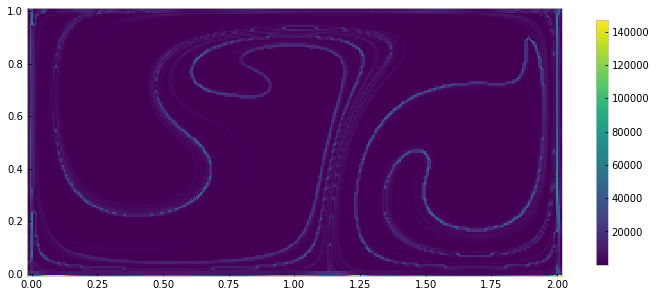

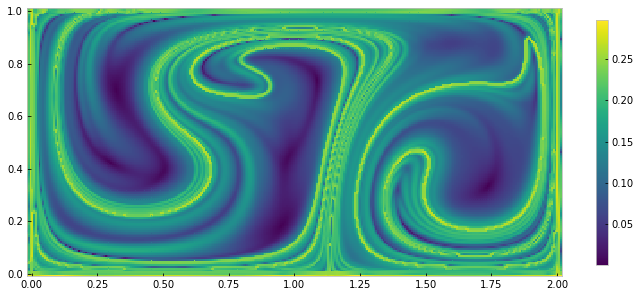

In [27]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lambda2)
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)
plt.savefig('eigen_vals' + fig_num + '.png')


fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(lambda2)/(2*tmax))
plt.colorbar(mesh, shrink = 0.9)
plt.xlim(-0.02, 2.02)
plt.ylim(-0.01, 1.01)

In [ ]:
Atol = 0.0
Atrue = np.logical_and(np.abs(lambda1 - lambda2) > Atol, lambda2 - 1. > Atol)
#Atrue = np.logical_and(lambda2 == lambda2, lambda2 == lambda2)
print('Number of points where A is true: ', np.sum(Atrue))



lmbd = lambda2.reshape((Nx,Ny))
    
hessian = np.zeros((Nx,Ny,2,2))
    
# First, the laplacian terms:
    
# Internal points: Centered differences
hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dxm**2)
hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dym**2)
    
    # Near boundaries: Higher order forwards/backwards differences
hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dxm**2)
hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dxm**2)
    
hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dym**2)
hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dym**2)

# Then, the mixed derivatives:
dldx = np.empty((Nx,Ny))
dldy = np.empty((Nx,Ny))

# Internal points: Centered differences
dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dxm)
dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dxm)
dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dxm)

dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dym)
dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dym)



# Same deal for the mixed derivatives
d2ldxdy = np.empty((Nx,Ny))
d2ldydx = np.empty((Nx,Ny))

# Internal points: Centered differences
d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dxm)
d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dxm)
d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dxm)

d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dym)
d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dym)

hessian[:,:,0,1] = d2ldxdy
hessian[:,:,1,0] = d2ldydx

hessian = hessian[:,:,:,:].reshape(((Nx)*(Ny), 2, 2))
xi2_m = xi2.reshape((Nx*Ny), 2)
# Taking inner product, although it seems useless
#inner   = np.sum(xi1 * (hessian)[:,:,0] * xi1, axis = -1)
inner = np.sum(xi2_m * np.sum(hessian*xi2_m[...,np.newaxis], axis=1), axis=1)
Btol = 0.0
inner = inner.reshape((Nx,Ny))
Btrue   = inner  <= Btol
print('Number of points where B is true: ', np.sum(Btrue))

ABtrue = np.logical_and(Atrue, Btrue)

print('Number of points where A and B is true: ', np.sum(ABtrue))

In [ ]:
mask = np.zeros((Nx, Ny), dtype = np.bool)
for i in range(1,5):
    mask[:,min( int(i*Ny/5), Ny-1)] = True
    mask[min( int(i*Nx/5), Nx-1),:] = True

Gx = X0m[0,:,:][np.logical_and(mask, ABtrue)]
Gy = X0m[1,:,:][np.logical_and(mask, ABtrue)]

G = np.array([Gx, Gy])

print('G has %s points' % G.shape[1])

In [ ]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[1] - xc[0]
        self.dy = yc[1] - yc[0]
        self.xi = xi
        self.Nx = len(xc)
        self.Ny = len(yc)
        self.fold = None
        
    def __call__(self, X, t):
        # Calculate indices for lower left corner in cell
        i = np.floor((X[0] - self.xc[0]) / self.dx).astype(np.int32)
        j = np.floor((X[1] - self.yc[0]) / self.dy).astype(np.int32)
        
        # If outside the domain, stop
        if (i >= Nx - 2) or (j >= Ny - 2) or (i < 0) or (j < 0):
            raise IndexError
        
        # Use the lower left corner as reference, calculate
        # the rotation of the other vectors, and rotate by 180
        # degrees if required (due to orientational discontinuity)
        subxi = self.xi[:,i:i+2, j:j+2].copy()
        dotp = np.sum(subxi[:,0,0].reshape(2,1,1) * subxi, axis = 0)
        subxi[:, dotp < 0] =  -subxi[:, dotp < 0]
        
        # Linear interpolation
        Wx0 = (self.xc[i+1] - X[0]) / self.dx
        Wx1 = 1 - Wx0
        Wy0 = (self.yc[j+1] - X[1]) / self.dy
        Wy1 = 1 - Wy0

        V = Wy0*(Wx0*subxi[:,0,0] + Wx1*subxi[:,1,0]) + Wy1*(Wx0*subxi[:,0,1] + Wx1*subxi[:,1,1])
                
        # Check orientation against previous vector
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip direction
            return V * np.sign(np.dot(V, self.fold))
            
def half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm, max_notAB = 0.3, t=0):
    # Re-initialise the f-function
    f.fold = None

    Nt = int((Tmax-t) / h)
    xs = np.zeros((2, Nt))
    xs[:,0] = x0
    dx = xc[1] - xc[0]
    dy = yc[1] - yc[0]
    
    # Buffer zone outside domain
    xbuf = 0.01
    ybuf = 0.005
    
    # Parameters of strainline
    length = 0.0
    notABlength = 0.0
    mulambda = 0.0

    for n in range(1, Nt):
        f.fold = f(xs[:,n-1], t)
        try:
            xs[:,n] = rk4(xs[:,n-1], t, pm*h, f)
        except IndexError:
            break
        if xs[0,n] < (0.0-xbuf) or (2.0+xbuf) < xs[0,n] or xs[1,n] < (0.0-ybuf) or (1.0+ybuf) < xs[1,n]:
            break
        if notABlength > max_notAB:
            break

        # increment length
        dl = np.sqrt(np.sum((xs[:,n] - xs[:,n-1])**2))
        length += dl
        # calculate closest grid point
        i = np.floor(((xs[0,n]+dx/2) - xc[0]) / dx).astype(np.int32)
        j = np.floor(((xs[1,n]+dy/2) - yc[0]) / dy).astype(np.int32)
        # Use this to look up lambda2, and add to running total
        mulambda += lambda2[i,j] * dl
        # Check if A and B are satisfied
        if ABtrue[i, j]:
            notABlength = 0
        else:
            notABlength += dl

    if length > 0:
        mulambda = mulambda / length
    else:
        mulambda = 0.0
    return xs[:,:n], length, mulambda

def strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, max_notAB = 0.3, t=0):
    line1, length1, mulambda1 = half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm = +1, max_notAB = max_notAB, t=t)
    line2, length2, mulambda2 = half_strainline(x0, Tmax, h, f, xc, yc, lambda2, ABtrue, pm = -1, max_notAB = max_notAB, t=t)
    length = length1 + length2
    if length > 0:
        mulambda = (length1*mulambda1 + length2*mulambda2) / length
    else:
        mulambda = 0.0
    N1  = line1.shape[1]
    N2  = line2.shape[1]
    line = np.zeros((2, N1+N2-1))
    line[:,:N1] = line1[:,::-1]
    line[:,N1:] = line2[:,1:]
    return line, length, mulambda

In [ ]:
# 1D-arrays of grid coordinates for convenience
xc = X0m[0,:,0]
yc = X0m[1,0,:]

# Create interpolator object, with the eigenvector field
# corresponding to the smallest eigenvalues

EigVec = np.zeros((2, 2, xi1.shape[0], xi1.shape[1]))
EigVec[:, 0, :, :] = np.rollaxis(xi1, 2, 0)
EigVec[:, 1, :, :] = np.rollaxis(xi2, 2, 0)

print(lambda2.shape)
EigVal = np.zeros((2, lambda2.shape[0], lambda2.shape[1]))
EigVal[0, :, :] = lambda1
EigVal[1, :, :] = lambda2

f_xi = LinearSpecial(xc, yc, EigVec[:,0,:,:])

# List to hold strainlines and associated parameters
# (number not known ahead of time, hence lists)
strainlines   = []
lengths       = []
lengths_notAB = []
eigvals_mean  = []

# Filtering parameters
max_notAB  = 0.2
min_length = 1.0
# Trajectory integration parameters
# Note: "Speed" is 1 everywhere, since eigenvectors
# are normalised. Thus Tmax gives max length directly
Tmax = 1*(TMAX )
h    = strain_res

progressbar = FloatProgress(min=0, max=G.shape[1])
display(progressbar)

futures = []
with ProcessPoolExecutor(8) as executor:
    for i in range(G.shape[1]):
        progressbar.value += 1
        futures.append(executor.submit(strainline, G[:,i], Tmax, h, f_xi, xc, yc, EigVal[1,:,:], ABtrue, max_notAB = max_notAB, t=t0))
    

progressbar = FloatProgress(min=0, max=G.shape[1])
display(progressbar)
for p in as_completed(futures):
    progressbar.value += 1
    try:
        line, length, eigval_mean = p.result()
        if length > min_length:
            strainlines.append(line)
            lengths.append(length)
            eigvals_mean.append(eigval_mean)
    except IndexError:
        pass

print('Identified %s LCS candidates' % len(strainlines))

In [ ]:
# 1D-arrays of grid coordinates for convenience
xc = X0m[0,:,0]
yc = X0m[1,0,:]
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

inside_eigvals  = []
running_eigvals = []
running_ABtrues = []

progressbar = FloatProgress(min=0, max=len(strainlines))
display(progressbar)

fLCSs = strainlines
flengths = lengths

for i in range(len(strainlines)):
    progressbar.value += 1
    eigvals = np.zeros(strainlines[i].shape[1])
    ABtrues = np.zeros(strainlines[i].shape[1], dtype = np.bool)
    for n in range(strainlines[i].shape[1]):
        igrid = np.floor(((strainlines[i][0,n]+dx/2) - xc[0]) / dx).astype(np.int32)
        jgrid = np.floor(((strainlines[i][1,n]+dy/2) - yc[0]) / dy).astype(np.int32)
        if ABtrue[igrid, jgrid]:
            ABtrues[n] = True
            eigvals[n] = EigVal[1,igrid,jgrid]
    inside_eigvals.append(np.sum(eigvals[ABtrues]) / np.sum(ABtrues))
    running_eigvals.append(eigvals)
    running_ABtrues.append(ABtrues)

In [ ]:
#temps

temp_flcs = fLCSs
temp_lens = flengths
temp_eigs = eigvals_mean

In [ ]:
fLCSs = temp_flcs
flengths = temp_lens
eigvals_mean = temp_eigs

In [ ]:
#removing shorter lines
new_lines = []
new_lens = []
new_eigs_mean = []
maks = np.max(flengths)
# print(0.3*maks)
for i in range(len(fLCSs)):
    if flengths[i] > 0.2*maks:
        new_lines.append(fLCSs[i])
        new_lens.append(flengths[i])
        new_eigs_mean.append(eigvals_mean[i])
print(len(fLCSs))
fLCSs = new_lines
flengths = new_lens
eigvals_mean = new_eigs_mean
print(len(fLCSs))

In [ ]:
# start variables:
# search through longest array and find if shortest starts and ends somewhere on the longest line

# should be possible to iterate through both these lines the same way because the step is the same
# thus if they follow eachother - > should work

# dist = (fLCSs[i][j + start_i,0] - fLCSs[k][j + start_k,0])**2 + (fLCSs[i][j + start_i,1] - fLCSs[k][j + start_k,1])**2
# dist = np.sqrt(dist)

def searcher(short_line, long_line, epsilon):
    tol = 0.4
    if len(short_line[0,:]) > len(long_line[0,:]): 
        print('one faulty boi')
        return -1, -1
    x0, y0 = short_line[:,  0]
    x1, y1 = short_line[:, -1]
    u0, v0 = long_line[:,   0]
    u1, v1 = long_line[:,  -1]
    start = -1
    end = -1
    short = 1 # bool for checking which line to start with
    len_s = len(short_line[0,:])
    len_l = len(long_line[ 0,:])
    #check if short line starts on the long one
    dists = np.sqrt((long_line[0,:] - x0)**2 + (long_line[1,:] - y0)**2)
    start = np.argmin(dists)
    if dists[start] < epsilon:

        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end-start) > tol * len_l:
#                 print('1')
                return start, end, short
            else:
#                 print('2')
                return start, -1, short
        
        dists = np.sqrt((short_line[0,:] - u1)**2 + (short_line[1,:] - v1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end) > tol * len_l:
#                 print('3')
                return start, len_l - start - 1, short
            else:
#                 print('4')
                return -1, -1, short
        else:
#             print('5')
            return start, -1, short

    else: #if short line dont start on the long line -> check other way around
        short = 0
        dists = np.sqrt((short_line[0,:] - u0)**2 + (short_line[1,:] - v0)**2)
        start = np.argmin(dists)
        if dists[start] > epsilon:
#             print('10')
            return -1, -1, short
        
        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] > 1*epsilon:
#             print('11')
            return start, -1, short
        else:
            if (len_s - start) > tol * len_l:
#                 print('12')
#                 print('ha')
                return start, len_s - start - 1, short
            else: 
#                 print('13')
                return -1, -1, short
#     print('100')
    return start, end, short
        
        
       
        
    

#inner_loop funk


def inner_looper(fLCSs, i, epsilon):
#     print(fLCSs)
    dist = np.zeros(len(fLCSs))
    for j in range(len(fLCSs)):
        if i == j: continue
        len_i = len(fLCSs[i][0,:])
        len_j = len(fLCSs[j][0,:])
        len_short = 0
        end = 0
        start = 0
        nul_val = -1
        correction = 0
        if len_j > len_i:
            start, end, order = searcher(fLCSs[i], fLCSs[j], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp
#             print('start %d' % start)
#             print('end % d' % end)
            len_short = end - start
            if order:
                start_iter_j = start
                start_iter_i = 0
            else:
                start_iter_i = start
                start_iter_j = 0
            if len_short > len(fLCSs[i][0,:]):
                correction = len_short-len(fLCSs[i][0,:])   
        else:
            start, end, order = searcher(fLCSs[j], fLCSs[i], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp
#             print('start %d' % start)
#             print('end % d' % end)
            len_short = end - start
            if order:
                start_iter_j = 0
                start_iter_i = start
            else:
                start_iter_i = 0
                start_iter_j = start
            if len_short > len(fLCSs[j][0,:]):
                correction = len_short-len(fLCSs[j][0,:]) 
                
        
        
        
        
        if end == -1 or start_iter_i == -1 or start_iter_j == -1:
            dist[j] = nul_val
            continue
        #print('len %d ' %len_short)
        #print('start %d ' %start_iter_j)
        #print('end %d' % end)


        distances = np.zeros(len_short)
        #for k in range(len_short-end):
            #print('k: %d' % k)
            #print('start_iter_i: %d' % start_iter_i)
        
#         if len_short > len(fLCSs[i][0,:]):
#             correction = len_short-len(fLCSs[i][0,:])
# #             if len_short < 0.5 * len(fLCSs[j][0,:]):
# #                 dist[j] = nul_val
# #                 continue
#         else:
#             if len_short > len(fLCSs[j][0,:]):
#                 correction = len_short-len(fLCSs[j][0,:])
# #             if len_short < 0.5 * len(fLCSs[i][0,:]):
# #                 dist[j] = nul_val
# #                 continue
                
        len_short -= correction
        if len_short < 1:
            dist[j] = nul_val
            continue
        len_ii = start_iter_i + len_short
        len_jj = start_iter_j + len_short
        
        

        distances = np.sqrt((fLCSs[i][0,start_iter_i:len_ii] - fLCSs[j][0, start_iter_j:len_jj])**2 \
                        + (fLCSs[i][1,start_iter_i:len_ii] - fLCSs[j][1, start_iter_j:len_jj])**2)
#         if np.amax(distances) > 1*epsilon:
#             dist[j] = nul_val
#             continue
        dist[j] = np.sum((distances))
        dist[j] = dist[j] / len_short
        
    return dist

# normalize over length of shortest line
   


In [ ]:
# flengths,fLCSs, eigvals_mean = (zip(*sorted(list(zip(flengths, fLCSs, eigvals_mean)))))

# import random
# fLCSs = strainlines

# # fig_num = '2'
# c = list(zip(fLCSs, flengths, eigvals_mean))
# #andom.shuffle(c)
# fLCSs, flengths, eigvals_mean = zip(*c)
# #print(fLCSs[0])

nearest_nbs = np.zeros((len(fLCSs), len(fLCSs)))
nearest_nbs.shape
print(fLCSs[0].shape)
epsilon = 0.2

# Progress bar
progressbar = FloatProgress(min = 0, max = int(len(fLCSs) / 20))
display(progressbar)

#first loop: iterate over all lines
##IS THIS SYMMETRIC? problem size could possibly be reduced by factor 2 
short_fLCSs = []
for i in range(len(fLCSs)):
    line = fLCSs[i][:,::4]
    short_fLCSs.append(line)
for i in range(len(fLCSs)):
        nearest_nbs[i,:] = inner_looper(short_fLCSs, i, epsilon)
        if i % 20 == 0: progressbar.value += 1

In [ ]:
# print(nearest_nbs)            
nearest_nbs = np.where(np.isnan(nearest_nbs), 0, nearest_nbs)
nearest_nbs_test = np.where(nearest_nbs == 0, 1, nearest_nbs)
nearest_nbs_inv = np.where(nearest_nbs != 0, np.divide(1, nearest_nbs), 0)


In [ ]:
fig = plt.figure(figsize=(16,8))

plotted = set([])
mult = 1
   



for i in range(len(fLCSs)):
    if i not in plotted:
        line1 = fLCSs[i]
        I, = plt.plot(line1[0,:], line1[1,:])
        plotted.add(i)
        threshold = mult*np.mean(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        for j in range(len(fLCSs)):
            if j not in plotted:
                if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                    line2 = fLCSs[j]
                    plt.plot(line2[0,:], line2[1,:], c = I.get_color())
                    plotted.add(j)

In [ ]:
# fig = plt.figure(figsize=(16,8))
num =8
mult = 1
   
threshold = mult*np.mean(nearest_nbs_inv[num,np.where(nearest_nbs_inv[num,:] > 0 )])

#%maplotlib notebook


plt.plot(np.linspace(0,nearest_nbs.shape[0], nearest_nbs.shape[0]),nearest_nbs_inv[num,:],'o')
#pick closest lines
friendsof_num = np.where(nearest_nbs_inv[num,:] > threshold )
friendsof_num[0]
fig = plt.figure(figsize=(16,8))
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
for i in range(len(fLCSs)):
#     i = friendsof_73[j]
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
    
# fig = plt.figure(figsize=(16,8))
# plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
# for i in range(len(fLCSs)):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
# plt.xlim([1.6,1.75])
# plt.ylim([0.8, 1])

#plot to see if it makes sense
fig = plt.figure(figsize=(16,8))
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 3 )
for i in set(friendsof_num[0]):
#     i = friendsof_73[j]
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 1, alpha=0.25)
    
print(friendsof_num[0])
print(threshold)

In [ ]:
# fLCSs = strainlines
minn = len(fLCSs[0][0,:])
maxx = 0
for i in range(len(fLCSs)):
    if(len(fLCSs[i][0,:]) < minn):
        minn = len(fLCSs[i][0,:])
    if(len(fLCSs[i][0,:]) > maxx):
        maxx = len(fLCSs[i][0,:])

print('max length of LCS: %d' % maxx)
print('min length of LCS: %d' % minn)

from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn import datasets, cluster
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D

size = minn
X = np.zeros((len(fLCSs), size))
y = np.zeros((len(fLCSs), size))
eigs = np.zeros((len(fLCSs), size))
for i in range(len(fLCSs)):
    ratio = 1 - len(fLCSs[i][0,:]) / size
    multiplier = int(len(fLCSs[i][0,:]) / size)
    offset = 0


    for j in range(size):#len(fLCSs[i][0,:])):
        
        X[i, j + offset] = fLCSs[i][0, j * multiplier]
        y[i, j + offset] = fLCSs[i][1, j * multiplier]



n_comps = 25
kpca0 = KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=n_comps)
kpca1 = KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=n_comps)
kpca2 = KernelPCA(kernel="linear", fit_inverse_transform=True, n_components=n_comps)
kpca3 = KernelPCA(kernel="poly", fit_inverse_transform=True, n_components=n_comps)
X_kpca0 = kpca0.fit_transform(X, y)
# #X_kpca0 = kpca0.fit_transform(X_kpca0, nearest_nbs_inv)

X_kpca1 = kpca1.fit_transform(X, y)
X_kpca1 = kpca1.fit_transform(X_kpca1, nearest_nbs_inv)

X_kpca2 = kpca2.fit_transform(X, y)
# X_kpca2 = kpca2.fit_transform(X_kpca2, nearest_nbs_inv)

X_kpca3 = kpca3.fit_transform(X, y)
#X_kpca3 = kpca3.fit_transform(X_kpca3, nearest_nbs_inv)
NEIGH_feats = kpca0.fit_transform(nearest_nbs)
print('done')


In [ ]:
X_new = X_kpca1[:,0::]
#X_kpca = kpca1.fit_transform(X_kpca, nearest_nbs)
print(X_new.shape)
# #fig = plt.figure(figsize=(16,8))
# plt.scatter(X_kpca[:,0], X_kpca[:,1])
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs=X_new[:,0], ys=X_new[:,1], zs=X_new[:,2], zdir='z')
plt.show()

X_new = X_new#[:, ::1]
# fig = plt.figure(figsize=(16,8))
plt.scatter(X_new[:,0], X_new[:,1], color = 'k')
print(X_new.shape)

In [ ]:
def find_max_lcss(fLCSs, n_clusters_, labels, flen, flambs):
    num_clust = n_clusters_

    #flengths
    #eigvals_mean

    #array for holding the selected LCSs
    chosen_LCS = []
    #find which lines belong to a cluster
    
    
    ####need to fix here for second run -- cant multiply by step and expect correct indices. mapping?
    len_min = 1.0
    for k in range(num_clust):
        #print("cluster %d  " %k)
        my_members = labels == k
        if(my_members.size == 1): continue
        indices = np.where(my_members)
        #print((indices))
        local_lines = []
        if (len(indices[0]) < 3 or indices[0] is None):
            continue
        for i in range(len(indices)):

            local_lines.append(indices[0][i])
    
        #local_lines = indices
        
        
        ind = 0
        identity = -1
        maxi_lamb = 0
        maxi_len = 0
        leng = len(local_lines)
        #print(local_lines)
        for i in set(local_lines):
            if flengths[i] > len_min:
                if eigvals_mean[i] > maxi_lamb:
                #if flengths[i] > flengths[identity]:# and (np.abs(eigvals_mean[i] - maxi_lamb) < 1e-1 or eigvals_mean[i] > maxi_lamb):
                    identity = i
                    maxi_lamb = eigvals_mean[i]
                    maxi_len = flengths[i] 
                else:
                    if eigvals_mean[i] == maxi_lamb and flengths[i] > maxi_len:
                        identity = i
                        maxi_len = flengths[i]
                        maxi_lamb = eigvals_mean[i]
        if identity not in chosen_LCS and identity != -1: chosen_LCS.append(identity)
        #print("identity: %d \n" % identity)

    print(chosen_LCS)

    return chosen_LCS

In [ ]:
def cherryPicker(chosen_LCS, flambs, nearest_nbs_inv, epsilon, mult=1):
    count = len(chosen_LCS)
    num_lines = len(nearest_nbs_inv[0,:])
    new_chosen = []
    for i in set(chosen_LCS):
        #trying mean rather than median
        threshold = mult*np.mean(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        similars = []
        similars.append(i)
        for j in set(chosen_LCS):
            if i == j: continue
            if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                similars.append(j)
        line = i
        for k in range(len(similars)):
            if flambs[i] < flambs[similars[k]]:
                line = similars[k]
        #try to weed out the weak
        for o in set(similars):
            if o in new_chosen:# and np.abs(flengths[o] - flengths[line]) > 0.7*max(flengths[o], flengths[line]):
                new_chosen.remove(o)
#                 print('removing')
        
        if line not in new_chosen:
            new_chosen.append(line)
    return new_chosen

In [ ]:
from sklearn.cluster import DBSCAN
X_ = X_new

# n_clusters_, labels, cluster_centers = ms_clust(X_, 12, 0.1, seed=seeds)


#n_clusters_, labels, core_samples_mask = db_scan_it(X_, 20, 25, 10)
epsil0 = 2
epsil = epsil0
_clust = 10
samps = 10
n_clusters_ = 0
while(n_clusters_ < _clust):
    db = DBSCAN(eps=epsil, min_samples=samps).fit(X_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
#     print(n_clusters_)
    epsil -= epsil0 / 40
    if epsil <= 0: 
        print('couldnt find shit')
        break
import time as tid
fig = plt.figure(figsize=(18,9))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=9)

    xy = X_[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    #plt.show()
    #tid.sleep(0.5)
plt.title('Estimated number of clusters: %d' % n_clusters_)

chosen_LCS = find_max_lcss(fLCSs, n_clusters_, labels, flengths, eigvals_mean)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(chosen_LCS):
    if(flengths[i] > maks*0.20): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2 )
# plt.savefig('Kpca_DB_' + fig_num +'.png')

In [ ]:

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=100)
# new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult=1)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('Kpca_DB_' + fig_num +'.png')

# print(chosen_LCS)
# print(new_chosen)

In [ ]:
chosen_LCS = [x for x in range(len(fLCSs))]

new_chosen = cherryPicker(chosen_LCS, eigvals_mean, nearest_nbs_inv, epsilon, mult = 1)
# new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 5)
# new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 2)
# new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = 1)
# new_chosen = cherryPicker(new_chosen, eigvals_mean, nearest_nbs_inv, epsilon, mult = .5)
maks = np.amax(flengths)
fig = plt.figure(figsize=(14,7))
plt.pcolormesh(X0[0,:,:], X0[1,:,:], ABtrue, cmap = plt.get_cmap('ocean_r'), alpha = 0.25)
for i in set(new_chosen):
    if(flengths[i] > maks*0.2): plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 2, alpha=0.8 )
plt.savefig('no_cluster_' + fig_num + '.png')